# WGAN-GP Training

## imports

In [11]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from models.WGANGP import WGANGP
from utils.loaders import load_safari, load_cifar
from keras.preprocessing.image import ImageDataGenerator

import pickle


In [6]:
RUN_ID = '0027'
RUN_FOLDER = os.path.join("./run", RUN_ID)
DATA_FOLDER = './data/celeb/'

BATCH_SIZE = 64
IMAGE_SIZE = 64

## data

In [7]:
data_gen = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)

x_train = data_gen.flow_from_directory(DATA_FOLDER
                                         , target_size = (IMAGE_SIZE,IMAGE_SIZE)
                                         , batch_size = BATCH_SIZE
                                         , shuffle = True
                                         , class_mode = 'input'
                                         , subset = "training"
                                            )

Found 202599 images belonging to 1 classes.


## architecture

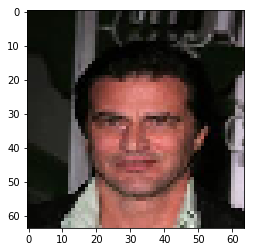

In [8]:
plt.imshow((x_train[0][0][0]+1)/2)

In [9]:
print(np.min(x_train[0][0]))
print(np.max(x_train[0][0]))

-1.0
1.0


In [14]:
model = pickle.load( open( os.path.join(RUN_FOLDER, "./model.pkl"), "rb" ) )

/Users/davidfoster/.virtualenvs/gdl/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


ValueError: Unknown layer: RandomWeightedAverage

In [10]:
#works

gan = WGANGP(input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
        , critic_conv_filters = [64,128,256,512]
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,2]
        , critic_conv_padding = 'same'
        , critic_batch_norm_momentum = None
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.0002
        , generator_initial_dense_layer_size = (4, 4, 512)
        , generator_upsample = [1,1,1,1]
        , generator_conv_filters = [256,128,64,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2,2,2]
        , generator_conv_padding = 'same'
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0002
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 100
        , batch_size = BATCH_SIZE
        )

gan.save(RUN_FOLDER)

In [ ]:
gan.load_weights(os.path.join(RUN_FOLDER, 'archive/weights/weights.h5'))

In [ ]:
gan.critic.summary()

In [ ]:
gan.generator.summary()

## training

In [ ]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = 20000
    , run_folder = RUN_FOLDER
    , print_every_n_batches = 5
    , n_critic = 5
    , using_generator = True
)

In [ ]:
gan.generator_learning_rate = 0.00005
gan.critic_learning_rate = 0.00005
gan.grad_weight = 10
gan._build_adversarial()

In [ ]:
gan.critic_model.metrics_names

In [ ]:
# Check weights updating

print([(np.min(x), np.max(x)) for x in gan.generator.get_weights()][:3])
print([(np.min(x), np.max(x)) for x in gan.critic.get_weights()][:3])
print('--- TRAIN CRITIC ---')
noise = np.random.normal(0, 1, (BATCH_SIZE, 100))
gen_imgs = gan.generator.predict(noise)
gan.train_critic(x_train, batch_size = BATCH_SIZE, using_generator = True)

print([(np.min(x), np.max(x)) for x in gan.generator.get_weights()][:3])
print([(np.min(x), np.max(x)) for x in gan.critic.get_weights()][:3])
print('--- TRAIN GENERATOR ---')
gan.train_generator(batch_size = BATCH_SIZE)

print([(np.min(x), np.max(x)) for x in gan.generator.get_weights()][:3])
print([(np.min(x), np.max(x)) for x in gan.critic.get_weights()][:3])

In [ ]:
check = True
while check :

    valid = np.ones((BATCH_SIZE,1), dtype=np.float32)
    fake = -np.ones((BATCH_SIZE,1), dtype=np.float32)
    dummy = np.zeros((BATCH_SIZE, 1), dtype=np.float32) # Dummy gt for gradient penalty
    
    true_imgs = next(x_train)[0]
    if true_imgs.shape[0] != BATCH_SIZE:
        true_imgs = next(x_train)[0]

    noise = np.random.normal(0, 1, (BATCH_SIZE, 100))
    
    d_loss = gan.critic_model.train_on_batch([true_imgs, noise], [valid, fake, dummy])
    # Plot the progress
    print ("[D loss: (%.1f)(R %.1f, F %.1f, G %.1f)]" % (d_loss[0], d_loss[1],d_loss[2],d_loss[3]))
    
    d_loss = gan.critic_model.test_on_batch([true_imgs, noise], [valid, fake, dummy])
    # Plot the progress
    print ("[D loss: (%.1f)(R %.1f, F %.1f, G %.1f)]" % (d_loss[0], d_loss[1],d_loss[2],d_loss[3]))
    

    print(gan.model.test_on_batch(noise, valid))
    
    
    
#     check = d_loss[4]<0.5 or d_loss[5]<0.5

In [ ]:
check = True
while check:
    valid = np.ones((BATCH_SIZE,1), dtype=np.float32)
    fake = -np.ones((BATCH_SIZE,1), dtype=np.float32)
    dummy = np.zeros((BATCH_SIZE, 1), dtype=np.float32) # Dummy gt for gradient penalty
    noise = np.random.normal(0, 1, (BATCH_SIZE,100))

    true_imgs = next(x_train)[0]
    
    
#     g_loss = gan.train_generator(batch_size = BATCH_SIZE)
    g_loss = gan.model.train_on_batch(noise, valid)
    # Plot the progress
    print ("[G loss: %.1f]" % (g_loss))
    
    g_loss = gan.model.test_on_batch(noise, valid)
    print ("[G loss: %.1f]" % (g_loss))
    
    
    print(gan.critic_model.test_on_batch([true_imgs, noise], [valid, fake, dummy]))



In [ ]:
noise = np.random.normal(0, 1, (BATCH_SIZE,100))
img = gan.generator.predict(np.array([noise[0]]))[0]

plt.imshow(np.clip((img+1)*0.5,0,1))

gan.critic.predict(np.array([img]))[0]

In [ ]:
img = next(x_train)[0][0]
print(gan.critic.predict(np.array([img]))[0])
plt.imshow((img + 1) * 0.5)

In [ ]:
valid = np.ones((BATCH_SIZE,1))
noise = np.random.normal(0, 1, (BATCH_SIZE,100))

In [ ]:
print(gan.model.test_on_batch(noise, valid))

In [ ]:
print(gan.model.train_on_batch(noise, valid))

In [ ]:
valid = np.ones((BATCH_SIZE,1), dtype=np.float32)
fake = -np.ones((BATCH_SIZE,1), dtype=np.float32)
dummy = np.zeros((BATCH_SIZE128, 1), dtype=np.float32) # Dummy gt for gradient penalty

true_imgs = next(x_train)[0]


In [ ]:
print(gan.critic_model.test_on_batch([true_imgs, noise], [valid, fake, dummy]))


In [ ]:
print(gan.critic_model.train_on_batch([true_imgs, noise], [valid, fake, dummy]))


In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()
